# Assignment 6
1. Use yeast dataset from UCI http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data
2. Remove the first column and use the last column as the target
3. Only leave CYT and VAC classes
4. Replace [0.3, 0.5, 0.7] in feature 2 to null
5. Replace [0.26, 0.36, 0.64] in feature 3 to null
6. Split the data

7. Impute the data (or not, it's your call)
8. Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1
9. Build a classifer using sample augmentation techniques to flassify VAC from CYT, i.e. 0 from 1
10. Try different methods and hyper paramters

11. Report perfromance using F-1 score

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data'
#df = pd.read_fwf(url)
df=pd.read_csv(url, header=None, delim_whitespace=True, names=['name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class_dist' ] )

In [3]:
df.shape

(1484, 10)

In [4]:
df.isnull().values.any()

False

In [5]:
df.head()

,name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class_dist
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [6]:
df['class_dist'].head()

0    MIT
1    MIT
2    MIT
3    NUC
4    MIT
Name: class_dist, dtype: object

In [7]:
# Only leave CYT and VAC classes
df_sliced = df[(df['class_dist'] == 'CYT') | (df['class_dist'] == 'VAC')]

In [8]:
df_sliced.class_dist.value_counts()

CYT    463
VAC     30
Name: class_dist, dtype: int64

In [9]:
#df_sliced.drop('name')
df_sliced.drop('name', inplace=True, axis=1)
df_sliced.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,mcg,gvh,alm,mit,erl,pox,vac,nuc,class_dist
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
12,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25,CYT
15,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22,CYT
16,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40,CYT


In [10]:
df_sliced_null=df_sliced.copy()

In [11]:
#Replace [0.3, 0.5, 0.7] in feature 2 to null
df_sliced_null['gvh'] = df_sliced_null['gvh'].replace([0.3, 0.5, 0.7], np.nan)

#Replace [0.26, 0.36, 0.64] in feature 3 to null
df_sliced_null['alm'] = df_sliced_null['alm'].replace([0.26, 0.36, 0.64], np.nan)

In [12]:
df_sliced_null.isnull().any()

mcg           False
gvh            True
alm            True
mit           False
erl           False
pox           False
vac           False
nuc           False
class_dist    False
dtype: bool

In [13]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder().fit_transform(df_sliced_null["class_dist"])
df_sliced_null["class_dist"] = LabelEncoder().fit_transform(df_sliced_null["class_dist"])
LabelEncoder().fit_transform(df_sliced["class_dist"])
df_sliced["class_dist"] = LabelEncoder().fit_transform(df_sliced["class_dist"])
#df_sliced_null.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
features = df_sliced_null.iloc[:,:-1]
target = df_sliced_null.iloc[:,-1]

X=features.values
y=target.values

# Split the data
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=63)

I have tried LogisticRegression and LinearSVC, and these classifiers can't handle dataset with missing values. Therefore, I will impute the missiing values first

In [15]:
# Impute the missing values
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
transformer = FeatureUnion(
     transformer_list=[
         ('features', SimpleImputer(strategy='mean')),
         ('indicators', MissingIndicator())])
transformer = transformer.fit(X_train, y_train)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = make_pipeline(transformer, DecisionTreeClassifier()).fit(X_train, y_train)
logreg = make_pipeline(transformer, LogisticRegression()).fit(X_train, y_train)
lsvc = make_pipeline(transformer, LinearSVC()).fit(X_train, y_train)
forest = make_pipeline(transformer, RandomForestClassifier()).fit(X_train, y_train)
#y_pred_clf = clf.predict(X_test)
#y_pred_logreg = logreg.predict(X_test)
#y_pred_lsvc = lsvc.predict(X_test)
#y_pred_forest = forest.predict(X_test)

print("Training set score using DecisionTreeClassifier: {:.2f}".format(clf.score(X_train, y_train)))
print("Test set score using DecisionTreeClassifier: {:.2f}".format(clf.score(X_test, y_test)))
#print("Accuracy using DecisionTreeClassifier: {:.2f}".format(accuracy_score(y_test, y_pred_clf)))
print("Training set score using LogisticRegression: {:.2f}".format(logreg.score(X_train, y_train)))
print("Test set score using LogisticRegression: {:.2f}".format(logreg.score(X_test, y_test)))
#print("Accuracy using LogisticRegression: {:.2f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Training set score using LinearSVC: {:.2f}".format(lsvc.score(X_train, y_train)))
print("Test set score using LinearSVC: {:.2f}".format(lsvc.score(X_test, y_test)))
#print("Accuracy using LinearSVC: {:.2f}".format(accuracy_score(y_test, y_pred_lsvc)))
print("Training set score using RandomForestClassifier: {:.2f}".format(forest.score(X_train, y_train)))
print("Test set score using RandomForestClassifier: {:.2f}".format(forest.score(X_test, y_test)))
#print("Accuracy using RandomForestClassifier: {:.2f}".format(accuracy_score(y_test, y_pred_forest)))

Training set score using DecisionTreeClassifier: 1.00
Test set score using DecisionTreeClassifier: 0.90
Training set score using LogisticRegression: 0.93
Test set score using LogisticRegression: 0.97
Training set score using LinearSVC: 0.93
Test set score using LinearSVC: 0.97
Training set score using RandomForestClassifier: 1.00
Test set score using RandomForestClassifier: 0.98


# Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1

In [17]:
from sklearn.ensemble import IsolationForest
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [18]:
# Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1
from sklearn.ensemble import IsolationForest
from numpy import quantile, where, random
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")
iforest = IsolationForest()
X_orig=df_sliced.iloc[:,:-1].values
y_orig=df_sliced.iloc[:,-1].values
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig)

param_grid = {'n_estimators': [50, 100, 200], 
              'max_samples': [2, 5, 10], 
              'contamination': ['auto', 0.0001, 0.0002], 
              'max_features': [5, 10, 15], 
              'bootstrap': [True], 
              'n_jobs': [-1]}

grid_search = model_selection.GridSearchCV(iforest, 
                                           param_grid,
                                           scoring="neg_mean_squared_error", 
                                           refit=True, 
                                           return_train_score=True)
grid_search.fit(X_train_orig, y_train_orig)

best_model = grid_search.fit(X_train_orig, y_train_orig)
print('Optimum parameters', best_model.best_params_)


Optimum parameters {'bootstrap': True, 'contamination': 'auto', 'max_features': 5, 'max_samples': 2, 'n_estimators': 50, 'n_jobs': -1}


In [19]:
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_orig, y_test_orig)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: -0.9376897445390597
Test score: -1.1693548387096775


In [20]:
# Now we will fit an IsolationForest model to the training data
iforest = IsolationForest(**best_model.best_params_)
y_pred = iforest.fit_predict(X_train_orig)
# We can now use the y_pred array to remove the offending values from the X_train and y_train data,
# and return the new X_train_iforest and y_train_iforest
X_train_iforest, y_train_iforest = X_train_orig[(y_pred != -1), :], y_train_orig[(y_pred != -1)]
print("Originial dataset shape: ", X_train_orig.shape, y_train_orig.shape)
print("After outlier removal: ", X_train_iforest.shape, y_train_iforest.shape)

Originial dataset shape:  (369, 8) (369,)
After outlier removal:  (369, 8) (369,)


In [21]:
# Using best parameters by gridsearchCV didn't identify any outlier. Let's try using basic parameters
iforest = IsolationForest()
y_pred = iforest.fit_predict(X_train_orig)
X_train_iforest, y_train_iforest = X_train_orig[(y_pred != -1), :], y_train_orig[(y_pred != -1)]
print("Originial dataset shape: ", X_train_orig.shape, y_train_orig.shape)
print("After outlier removal: ", X_train_iforest.shape, y_train_iforest.shape)

Originial dataset shape:  (369, 8) (369,)
After outlier removal:  (340, 8) (340,)


Therefore, this outlier detection method has identified some of the values as outlier. Let's try another method.

In [22]:
# Try DBSCAN for outlier detection
from sklearn.cluster import DBSCAN
dbscan = DBSCAN().fit(X_train_orig, y_train_orig)
y_pred_db = dbscan.fit_predict(X_train_orig)
X_train_dbscan, y_train_dbscan = X_train_orig[(y_pred_db != -1), :], y_train_orig[(y_pred_db != -1)]
print(X_train_orig.shape, y_train_orig.shape)
print(X_train_dbscan.shape, y_train_dbscan.shape)

(369, 8) (369,)
(364, 8) (364,)


DBSCAN also identified some values as outlier.

In [23]:
# Let's fit a classifier after removing these outliers
forest_orig = RandomForestClassifier().fit(X_train_orig, y_train_orig)
forest_IF = RandomForestClassifier().fit(X_train_iforest, y_train_iforest)
forest_DB = RandomForestClassifier().fit(X_train_dbscan, y_train_dbscan)
print("Training set score using RandomForestClassifier: {:.4f}".format(forest_orig.score(X_train_orig, y_train_orig)))
print("Test set score using RandomForestClassifier: {:.4f}".format(forest_orig.score(X_test_orig, y_test_orig)))
print("Test set score after IsolationForest: {:.4f}".format(forest_IF.score(X_test_orig, y_test_orig)))
print("Test set score after DBSCAN: {:.4f}".format(forest_DB.score(X_test_orig, y_test_orig)))

Training set score using RandomForestClassifier: 1.0000
Test set score using RandomForestClassifier: 0.9435
Test set score after IsolationForest: 0.9435
Test set score after DBSCAN: 0.9435


Therefore, outlier removal methods didn't improve the model scores significantly in this situation. Maybe this method would be useful in other situations.

In [24]:
def machine_learn(model, feature_train, feature_test, target_train, target_test):
    start = time.time()
    model_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('model', model)])
    fitted_model = model_pipeline.fit(feature_train, target_train)
    print("Accuracy Score:", fitted_model.score(feature_test, target_test))
    end = time.time()
    print('Time consumed {:.2f} seconds for this model'.format(end - start))
    model_preds = fitted_model.predict(feature_test)
    print(classification_report(target_test, model_preds))
    cm=confusion_matrix(target_test, model_preds)
    print(cm)
    sns.heatmap(cm, annot=True)

Accuracy Score: 0.9435483870967742
Time consumed 0.13 seconds for this model
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       117
           1       0.00      0.00      0.00         7

    accuracy                           0.94       124
   macro avg       0.47      0.50      0.49       124
weighted avg       0.89      0.94      0.92       124

[[117   0]
 [  7   0]]


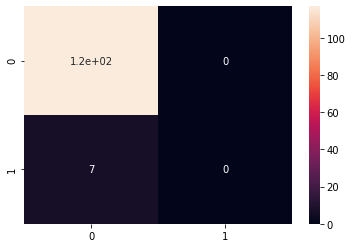

In [25]:
machine_learn(RandomForestClassifier(), X_train_orig, X_test_orig, y_train_orig, y_test_orig)

Accuracy Score: 0.9354838709677419
Time consumed 0.13 seconds for this model
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       117
           1       0.00      0.00      0.00         7

    accuracy                           0.94       124
   macro avg       0.47      0.50      0.48       124
weighted avg       0.89      0.94      0.91       124

[[116   1]
 [  7   0]]


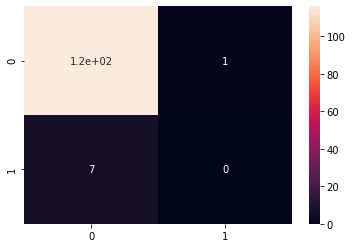

In [26]:
machine_learn(RandomForestClassifier(), X_train_iforest, X_test_orig, y_train_iforest, y_test_orig)

Accuracy Score: 0.9435483870967742
Time consumed 0.14 seconds for this model
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       117
           1       0.00      0.00      0.00         7

    accuracy                           0.94       124
   macro avg       0.47      0.50      0.49       124
weighted avg       0.89      0.94      0.92       124

[[117   0]
 [  7   0]]


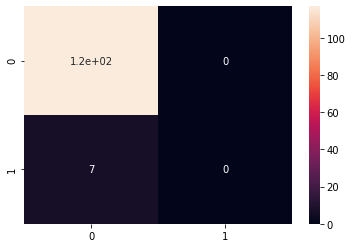

In [27]:
machine_learn(RandomForestClassifier(), X_train_dbscan, X_test_orig, y_train_dbscan, y_test_orig)

# Build a classifer using sample augmentation techniques to flassify VAC from CYT, i.e. 0 from 1

Original target counts:
0    343
1     26
Name: 0, dtype: int64


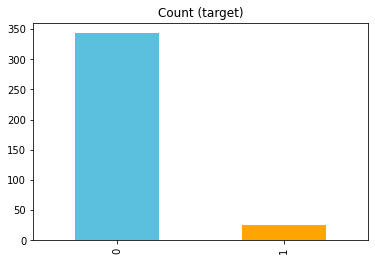

In [28]:
df_train = pd.DataFrame(y_train)
#print(df_train.iloc[:,-1].value_counts)
df_class_0 = df_train[df_train.iloc[:,-1] == 0]
df_class_1 = df_train[df_train.iloc[:,-1] == 1]
count_class_0, count_class_1 = df_train.iloc[:,-1].value_counts()
print('Original target counts:')
print(df_train.iloc[:,-1].value_counts())
df_train.iloc[:,-1].value_counts().plot.bar(title='Count (target)', color=('#5bc0de', 'orange'))

Random under-sampling:
1    26
0    26
Name: 0, dtype: int64


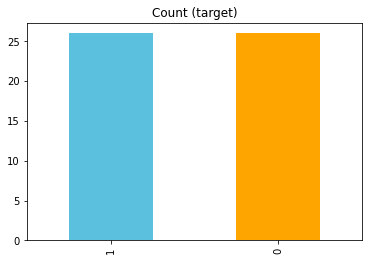

In [29]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.iloc[:,-1].value_counts())

#df_test_under.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)')
df_test_under.iloc[:,-1].value_counts().plot.bar(title='Count (target)', color=('#5bc0de', 'orange'))

Random over-sampling:
1    343
0    343
Name: 0, dtype: int64


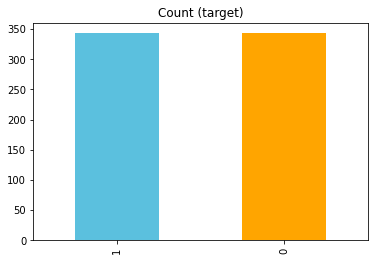

In [30]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.iloc[:,-1].value_counts())

df_test_over.iloc[:,-1].value_counts().plot.bar(title='Count (target)', color=('#5bc0de', 'orange'))

In [31]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

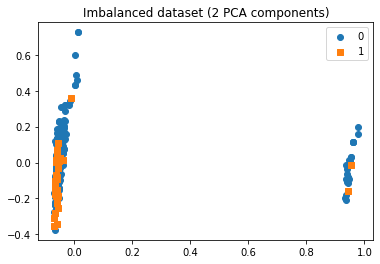

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#X = pca.fit_transform(X)
X=make_pipeline(transformer, pca).fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

In [33]:
!pip install imblearn
!pip install --upgrade scikit-learn
!pip install imbalanced-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.7/site-packages (1.0.1)


# Here, I needed to restart the kernel and rerun the following. Otherwise, it was giving error

In [34]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')

X_train_sm, y_train_sm = sm.fit_resample(X_train_orig, y_train_orig)

from sklearn.ensemble import GradientBoostingClassifier
clf_gb=GradientBoostingClassifier().fit(X_train_sm, y_train_sm)
clf_rf=RandomForestClassifier().fit(X_train_sm, y_train_sm)

print("Train set shape before SMOTE: ", X_train_orig.shape)
print("Train set shape after SMOTE: ", X_train_sm.shape)
print("Test set shape before SMOTE: ", y_train_orig.shape)
print("Test set shape after SMOTE: ", y_train_sm.shape)
print("Training set score using GradientBoostingClassifier: {:.2f}".format(clf_gb.score(X_train_sm, y_train_sm)))
print("Test set score using GradientBoostingClassifier: {:.2f}".format(clf_gb.score(X_test_orig, y_test_orig)))
print("Training set score using RandomForestClassifier: {:.2f}".format(clf_rf.score(X_train_sm, y_train_sm)))
print("Test set score using RandomForestClassifier: {:.2f}".format(clf_rf.score(X_test_orig, y_test_orig)))

Train set shape before SMOTE:  (369, 8)
Train set shape after SMOTE:  (692, 8)
Test set shape before SMOTE:  (369,)
Test set shape after SMOTE:  (692,)
Training set score using GradientBoostingClassifier: 0.99
Test set score using GradientBoostingClassifier: 0.90
Training set score using RandomForestClassifier: 1.00
Test set score using RandomForestClassifier: 0.90


In [35]:
def model_output(classifier, feature_train, feature_test, target_train, target_test):
    start = time.time()
    fitted_model = classifier
    print("Accuracy Score:", fitted_model.score(feature_test, target_test))
    end = time.time()
    print('Time consumed {:.2f} seconds for this model'.format(end - start))
    model_preds = fitted_model.predict(feature_test)
    print(classification_report(target_test, model_preds))
    cm=confusion_matrix(target_test, model_preds)
    print(cm)
    sns.heatmap(cm, annot=True)

Accuracy Score: 0.8951612903225806
Time consumed 0.00 seconds for this model
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       117
           1       0.00      0.00      0.00         7

    accuracy                           0.90       124
   macro avg       0.47      0.47      0.47       124
weighted avg       0.89      0.90      0.89       124

[[111   6]
 [  7   0]]


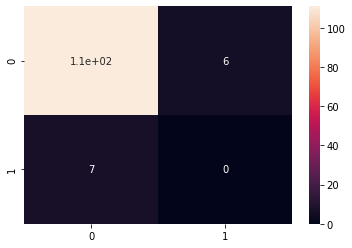

In [36]:
model_output(clf_gb, X_train_sm, X_test_orig, y_train_sm, y_test_orig)

Accuracy Score: 0.9032258064516129
Time consumed 0.01 seconds for this model
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       117
           1       0.00      0.00      0.00         7

    accuracy                           0.90       124
   macro avg       0.47      0.48      0.47       124
weighted avg       0.89      0.90      0.90       124

[[112   5]
 [  7   0]]


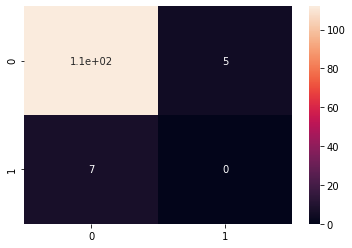

In [37]:
model_output(clf_rf, X_train_sm, X_test_orig, y_train_sm, y_test_orig)

In [38]:
# Trying a model with sclaing, gridsearch etc.
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__n_estimators':[5, 10, 20, 50, 100]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train_orig, y_train_orig)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_orig, y_test_orig)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.7581985792817877
Test score: 0.6172161172161172


This extra work didn't produce better result. Therefore, I would stick with the previous one for this problem.